Import All ressources, set float show for pandas

In [1]:
import pandas as pd
import urllib.request
import folium
import webbrowser
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import colormaps
from matplotlib.colors import Normalize, to_hex
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

url = "https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv"
urllib.request.urlretrieve(url, "2016_Building_Energy_Benchmarking.csv")
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', None)


Convert to dataframe

In [2]:
data = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

Creation of all function to manipulate or show the data

In [3]:
def create_barplot(ax, data, col):
    plot_data = data[col].value_counts()
    sns.barplot(x=plot_data.index, y=plot_data.values, ax=ax)
    ax.set_title(f'Count of {col}')
    ax.tick_params(axis='x', rotation=90, labelright=False)
    

def plot_barplots(data, columns):
    num_cols = len(columns)
    
    fig, axes = plt.subplots(num_cols, 1, figsize=(15, 10 * num_cols))
    axes = np.array(axes).flatten()
    
    list(map(create_barplot, axes[:num_cols], [data]*num_cols, columns))
    plt.tight_layout(pad=3.0)
    plt.show()

In [4]:
def nan_heatmap(data):
	plt.figure(figsize=(12, 10))
	sns.heatmap(data.isnull(), cbar=False)
	plt.xticks(rotation=45, ha='right')
	plt.title('Missing values heatmap')
	plt.show()

In [5]:
def create_boxplot(ax, data, col):
    sns.boxplot(x=data[col], ax=ax)
    ax.set_title(f'Distribution of {col}')

def plot_boxplots(data, columns):
    num_cols = len(columns)
    num_rows = num_cols // 2 + (num_cols % 2 > 0)
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
    axes = np.array(axes).flatten()
    
    list(map(create_boxplot, axes[:num_cols], [data]*num_cols, columns))
    
    plt.tight_layout()
    plt.show()

In [6]:
def convert_to_quantitative(df):
	data = df.copy()
	dummies_largest = pd.get_dummies(data['LargestPropertyUseType'], prefix='Largest')
	dummies_second = pd.get_dummies(data['SecondLargestPropertyUseType'], prefix='Second')
	dummies_third = pd.get_dummies(data['ThirdLargestPropertyUseType'], prefix='Third')

	categories = dummies_largest.columns.intersection(dummies_second.columns).intersection(dummies_third.columns)

	for category in categories:
		data[category] = (dummies_largest[f'Largest_{category}'] * data['LargestPropertyUseTypeGFA'] +
						  dummies_second[f'Second_{category}'] * data['SecondLargestPropertyUseTypeGFA'] +
						  dummies_third[f'Third_{category}'] * data['ThirdLargestPropertyUseTypeGFA'])
  
	for col in dummies_largest.columns:
		if col not in categories:
			data[col.replace('Largest_', '')] = dummies_largest[col] * data['LargestPropertyUseTypeGFA']

	for col in dummies_second.columns:
		if col not in categories:
			data[col.replace('Second_', '')] = dummies_second[col] * data['SecondLargestPropertyUseTypeGFA']

	for col in dummies_third.columns:
		if col not in categories:
			data[col.replace('Third_', '')] = dummies_third[col] * data['ThirdLargestPropertyUseTypeGFA']

	list_to_del = [
		'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
		'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
		'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
		'PrimaryPropertyType', 'BuildingType',
	]
	data_transformed = data.drop(columns=list_to_del)
	new_columns = list(categories) + [col.replace('Largest_', '').replace('Second_', '').replace('Third_', '') for col in dummies_largest.columns if col not in categories]
	return data_transformed, new_columns, list_to_del


In [7]:
def fill_property_use_types(data):
	data['LargestPropertyUseType'] = data['LargestPropertyUseType'].fillna('None')
	data['SecondLargestPropertyUseType'] = data['SecondLargestPropertyUseType'].fillna('None')
	data['ThirdLargestPropertyUseType'] = data['ThirdLargestPropertyUseType'].fillna('None')
	data['LargestPropertyUseTypeGFA'] = data['LargestPropertyUseTypeGFA'].fillna(0)
	data['SecondLargestPropertyUseTypeGFA'] = data['SecondLargestPropertyUseTypeGFA'].fillna(0)
	data['ThirdLargestPropertyUseTypeGFA'] = data['ThirdLargestPropertyUseTypeGFA'].fillna(0)
	imputer = KNNImputer(n_neighbors=10)
	data['ENERGYSTARScore'] = imputer.fit_transform(data['ENERGYSTARScore'].values.reshape(-1, 1))
	# data['ENERGYSTARScore'] = data['ENERGYSTARScore'].fillna(data['ENERGYSTARScore'].mean())
	return data

In [8]:
def plot_scaler(data, col, categories=None):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[col])

    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    print(f'Cumulative variance ratio for 2 components: {cumulative_variance_ratio[1]*100:.2f}%')
    print(f'component 3: {explained_variance_ratio[2]*100:.2f}%')

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    ax[0, 0].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    ax[0, 0].set_xlabel('Principal Component')
    ax[0, 0].set_ylabel('Explained Variance Ratio')
    ax[0, 0].set_title('Explained Variance Ratio by Principal Component')
    
    ax[0, 1].plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance_ratio)
    ax[0, 1].set_xlabel('Number of components')
    ax[0, 1].set_ylabel('Cumulative explained variance')
    ax[0, 1].set_title('Scree Plot')


    feature_names = data[col].columns
    if len(feature_names) > 2:
        for i in range(len(feature_names)):
            ax[1, 0].arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
                           head_width=0.05, head_length=0.05, color='blue')
    
        for i, feature in enumerate(feature_names):
            ax[1, 0].text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15, feature,
                          color='black', ha='center', va='center')
    
        ax[1, 0].set_xlim(-1, 1)
        ax[1, 0].set_ylim(-1, 1)
        ax[1, 0].set_xlabel('Principal Component 1')
        ax[1, 0].set_ylabel('Principal Component 2')
        ax[1, 0].set_title('Correlation Circle')
        ax[1, 0].grid()

    if categories is not None:
        scatter = ax[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=categories, cmap='viridis', alpha=0.5)
        ax[1, 1].set_xlabel('First principal component')
        ax[1, 1].set_ylabel('Second principal component')
        ax[1, 1].set_title('Projection of Individuals')
        cbar = plt.colorbar(scatter, ax=ax[1, 1], label='Category')
    plt.tight_layout()
    plt.show()

In [9]:
def get_color(value, vmin, vmax, cmap):
    norm = Normalize(vmin=vmin, vmax=vmax)
    color = cmap(norm(value))
    return to_hex(color)


def draw_map_conso(data):
    seattle_coords = [47.6062, -122.3321]
    mymap = folium.Map(location=seattle_coords, zoom_start=12)

    min_ghg = data['TotalGHGEmissions'].min()
    max_ghg = data['TotalGHGEmissions'].max()
    cmap = colormaps['viridis']

    for index, row in data.iterrows():
        ghg_color = get_color(row['TotalGHGEmissions'], min_ghg, max_ghg, cmap)
        
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=8,
            color=ghg_color,
            fill=True,
            fill_color=ghg_color,
            fill_opacity=0.7,
            popup=f"GHG Emissions: {row['TotalGHGEmissions']}<br>Energy Use: {row['SiteEnergyUse(kBtu)']}"
        ).add_to(mymap)

    mymap.save("map.html")
    webbrowser.open("map.html")


In [10]:
def draw_map(data):
    color_dict = {
        'NonResidential': 'blue',
        'Multifamily LR (1-4)': 'green',
        'Multifamily MR (5-9)': 'red',
        'Multifamily HR (10+)': 'purple',
        'SPS-District K-12': 'gray',
        'Campus': 'black',
        'Nonresidential COS': 'orange',
        'Nonresidential WA': 'pink'
    }

    seattle_coords = [47.6062, -122.3321]
    mymap = folium.Map(location=seattle_coords, zoom_start=12)
    for index, row in data.iterrows():
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=row['BuildingType'],
            icon=folium.Icon(color=color_dict.get(row['BuildingType'], 'white'))
        ).add_to(mymap)
    mymap.save("map.html")
    webbrowser.open("map.html")

In [11]:
def treat_outliers(data, thresholds):
    data_clean = data.copy()
    for col, (min_val, max_val) in thresholds.items():
        if col in data.columns:
            data_clean = data_clean[(data_clean[col] > min_val) & (data_clean[col] <= max_val)]
    return data_clean

In [12]:

def create_boxplot_subplot(x, ax, var, data, y):
    sns.boxplot(x=x, y=var, data=pd.concat([data, y], axis=1), ax=ax)
    ax.set_title(f'{var} per nutri grade')
    ax.tick_params(axis='x', rotation=45, labelright=False)

def multi_boxplots(x, data, y, numeric_columns):
    num_cols = len(numeric_columns)
    fig, axes = plt.subplots(num_cols, 1, figsize=(15, 20))
    list(map(create_boxplot_subplot, [x] * num_cols, axes, numeric_columns, [data] * num_cols, [y] * num_cols))
    plt.tight_layout()
    plt.show()

In [13]:
def plot_pairplots(data, col):
	sns.set_theme(style="ticks")
	sns.pairplot(data[col], diag_kind="kde", markers="o", plot_kws={'alpha': 0.6})
	plt.tight_layout()
	plt.show()

In [14]:
def prepare_data(data, subset_dup, keep):
    data_cleaned = data.copy()
    if subset_dup:
        data_cleaned = data_cleaned.drop_duplicates(subset=subset_dup)
    else:
        print("No target for subsetDup.")
    if 'BuildingType' in data_cleaned.columns:
        data_cleaned['BuildingType'] = data_cleaned['BuildingType'].fillna('')
        data_to_del = data_cleaned[data_cleaned['BuildingType'].str.contains('Multifamily')].index
        data_cleaned = data_cleaned.drop(data_to_del)
    X = data_cleaned
    
    
    return X

In [15]:
def setup_new_var(data):
	data['RatioElectricityUse'] = data['Electricity(kWh)'] / data['SiteEnergyUse(kBtu)']
	data['RatioNaturalGasUse'] = data['NaturalGas(therms)'] / data['SiteEnergyUse(kBtu)']
	data['RatioSteamUse'] = data['SteamUse(kBtu)'] / data['SiteEnergyUse(kBtu)']
	data['Age'] = 2024 - data['YearBuilt']
	data['EnergyPerBuilding'] = data['SiteEnergyUse(kBtu)'] / data['NumberofBuildings']
	return data

Show features of the data frame and missing data

In [16]:
var_list = data.columns.tolist()
print(var_list)
size_data = data.shape[0]
print(size_data)
missing_data = data.isnull().sum()/size_data
print(missing_data[missing_data
                   > 0.5])

['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions', 'GHGEmissionsIntensity']
3376
SecondLargestPropertyUseType      0.50
SecondLarge

Setup Variables 

In [17]:
subset_dup = ['OSEBuildingID']
filter = ['buildingType']
target = ['TotalGHGEmissions',
                 'SiteEnergyUse(kBtu)',
                ]
numeric_columns = ['NumberofBuildings',
                    'NumberofFloors',
                    'PropertyGFABuilding(s)',
                    'Age',
                    'EnergyPerBuilding',
                    'ENERGYSTARScore'
                   ]
ratio_columns = ['RatioElectricityUse',
                'RatioNaturalGasUse',
                'RatioSteamUse',
                ]
property_use_GFA = ['LargestPropertyUseTypeGFA',
                'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseTypeGFA',]
qualitative_columns = ['PrimaryPropertyType',
                        'BuildingType',
                        'LargestPropertyUseType',
                        'SecondLargestPropertyUseType',
                        'ThirdLargestPropertyUseType',
                       ]
coordinates = ['Latitude', 'Longitude']


First Clean, delete duplicates and remove Multifamily buildings

In [18]:
data = setup_new_var(data)
target = [col for col in target if col in data.columns]
numeric_columns = [col for col in numeric_columns if col in data.columns]
property_use_GFA = [col for col in property_use_GFA if col in data.columns]
qualitative_columns = [col for col in qualitative_columns if col in data.columns]
coordinates = [col for col in coordinates if col in data.columns]
ratio_columns = [col for col in ratio_columns if col in data.columns]
feature_keep = target + numeric_columns + qualitative_columns + property_use_GFA + coordinates + ratio_columns
X_clean = prepare_data(data, subset_dup, feature_keep)

Draw map in html to visualize buildings

In [19]:
draw_map(X_clean)

Drop the individuals this missing value in the main features (GHG Emissions, Site energy use)

In [20]:
rows_to_drop = X_clean.index[X_clean[target].isna().all(axis=1)]
X_clean = X_clean.drop(rows_to_drop)
print(f"Dropping {len(rows_to_drop)} rows with missing values in main features")

Dropping 2 rows with missing values in main features


------------------------------------------

### Univariate analysis
#### Qualitative - barplot to see different repartitions

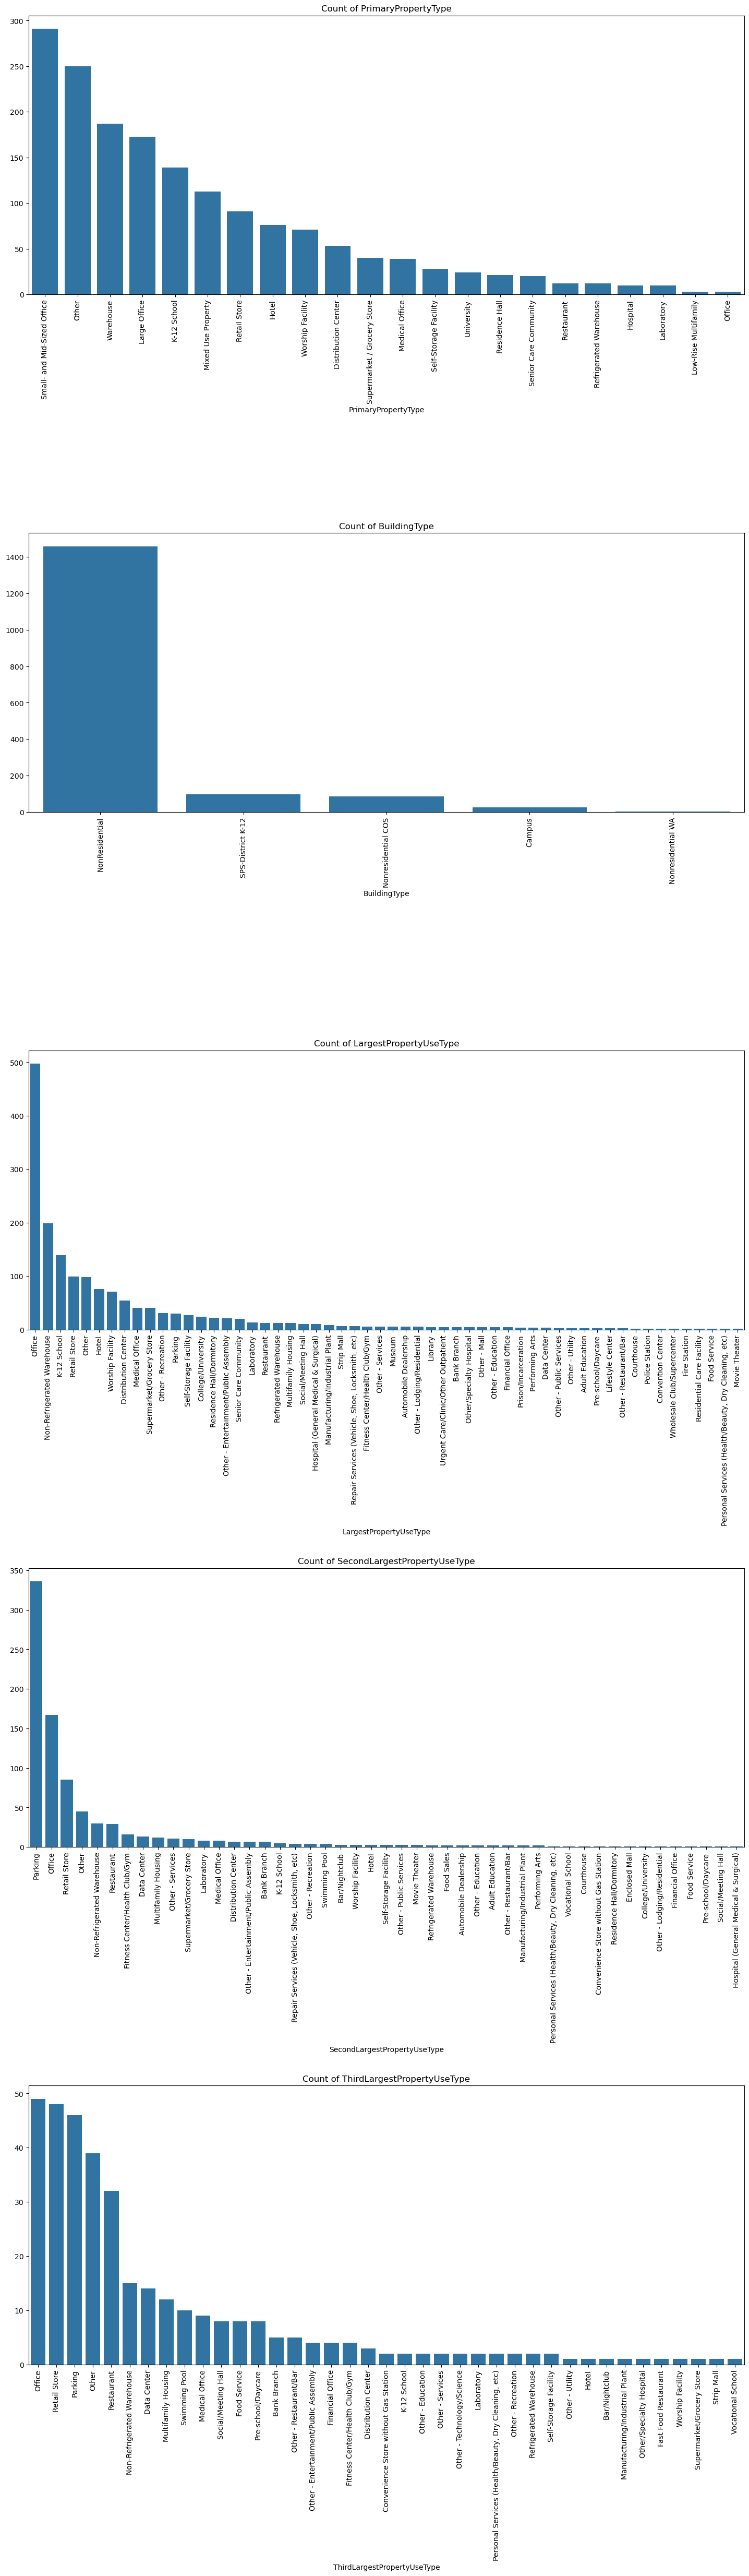

In [21]:
plot_barplots(X_clean, qualitative_columns)

Building type is just not usefull actualy, It was to delete residencial

Look what inside other

C:\Users\milan\AppData\Local\Temp\ipykernel_12804\4203081927.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=3.0)


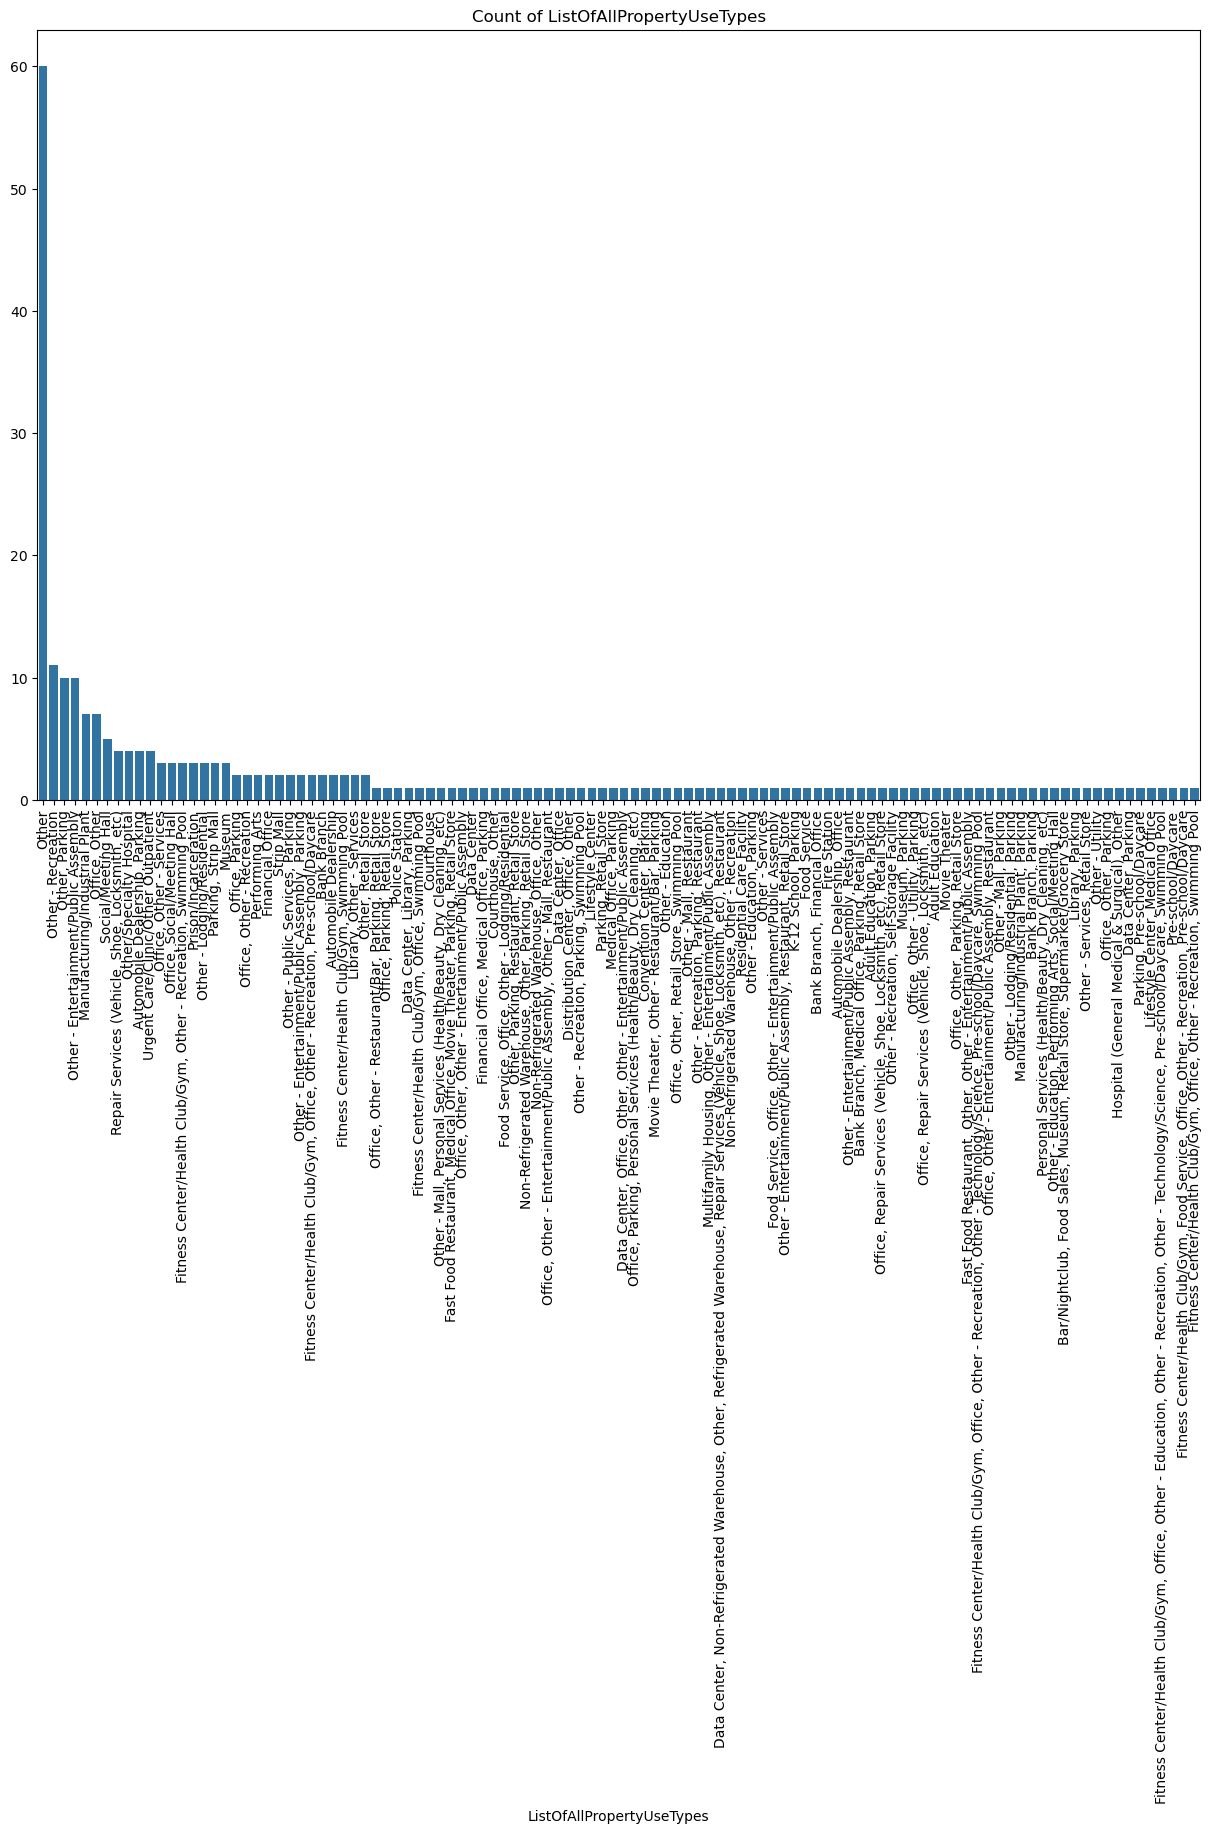

In [22]:
plot_barplots(X_clean[X_clean['PrimaryPropertyType'] == 'Other'], ['ListOfAllPropertyUseTypes'])

The bigest representation of other is other, so not usefull

Let's take a look in quantitative variable

In [23]:
X_clean[target + numeric_columns + property_use_GFA].describe()

c:\Users\milan\anaconda3\envs\oc\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,TotalGHGEmissions,SiteEnergyUse(kBtu),NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),Age,EnergyPerBuilding,ENERGYSTARScore,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
count,1666.00,1666.00,1666.00,1666.00,1666.00,1666.00,1666.00,1094.00,1662.00,855.00,353.00
mean,184.97,8437933.22,1.17,4.12,106021.56,62.04,inf,65.45,98764.69,36804.16,14923.14
std,751.98,30243803.39,2.93,6.57,284372.61,32.74,NaN,28.49,276711.06,69845.26,36790.56
min,-0.80,0.00,0.00,0.00,3636.00,9.00,0.00,1.00,5656.00,0.00,0.00
25%,19.97,1229290.84,1.00,1.00,28494.00,35.00,1214191.38,48.00,25527.50,5350.00,2663.00
50%,49.58,2554947.25,1.00,2.00,47391.50,59.00,2552392.88,73.00,43770.50,12000.00,5931.00
75%,142.38,6913348.50,1.00,4.00,94853.25,94.00,7424152.75,89.00,91983.75,31881.00,12941.00
max,16870.98,873923712.00,111.00,99.00,9320156.00,124.00,inf,100.00,9320156.00,686750.00,459748.00


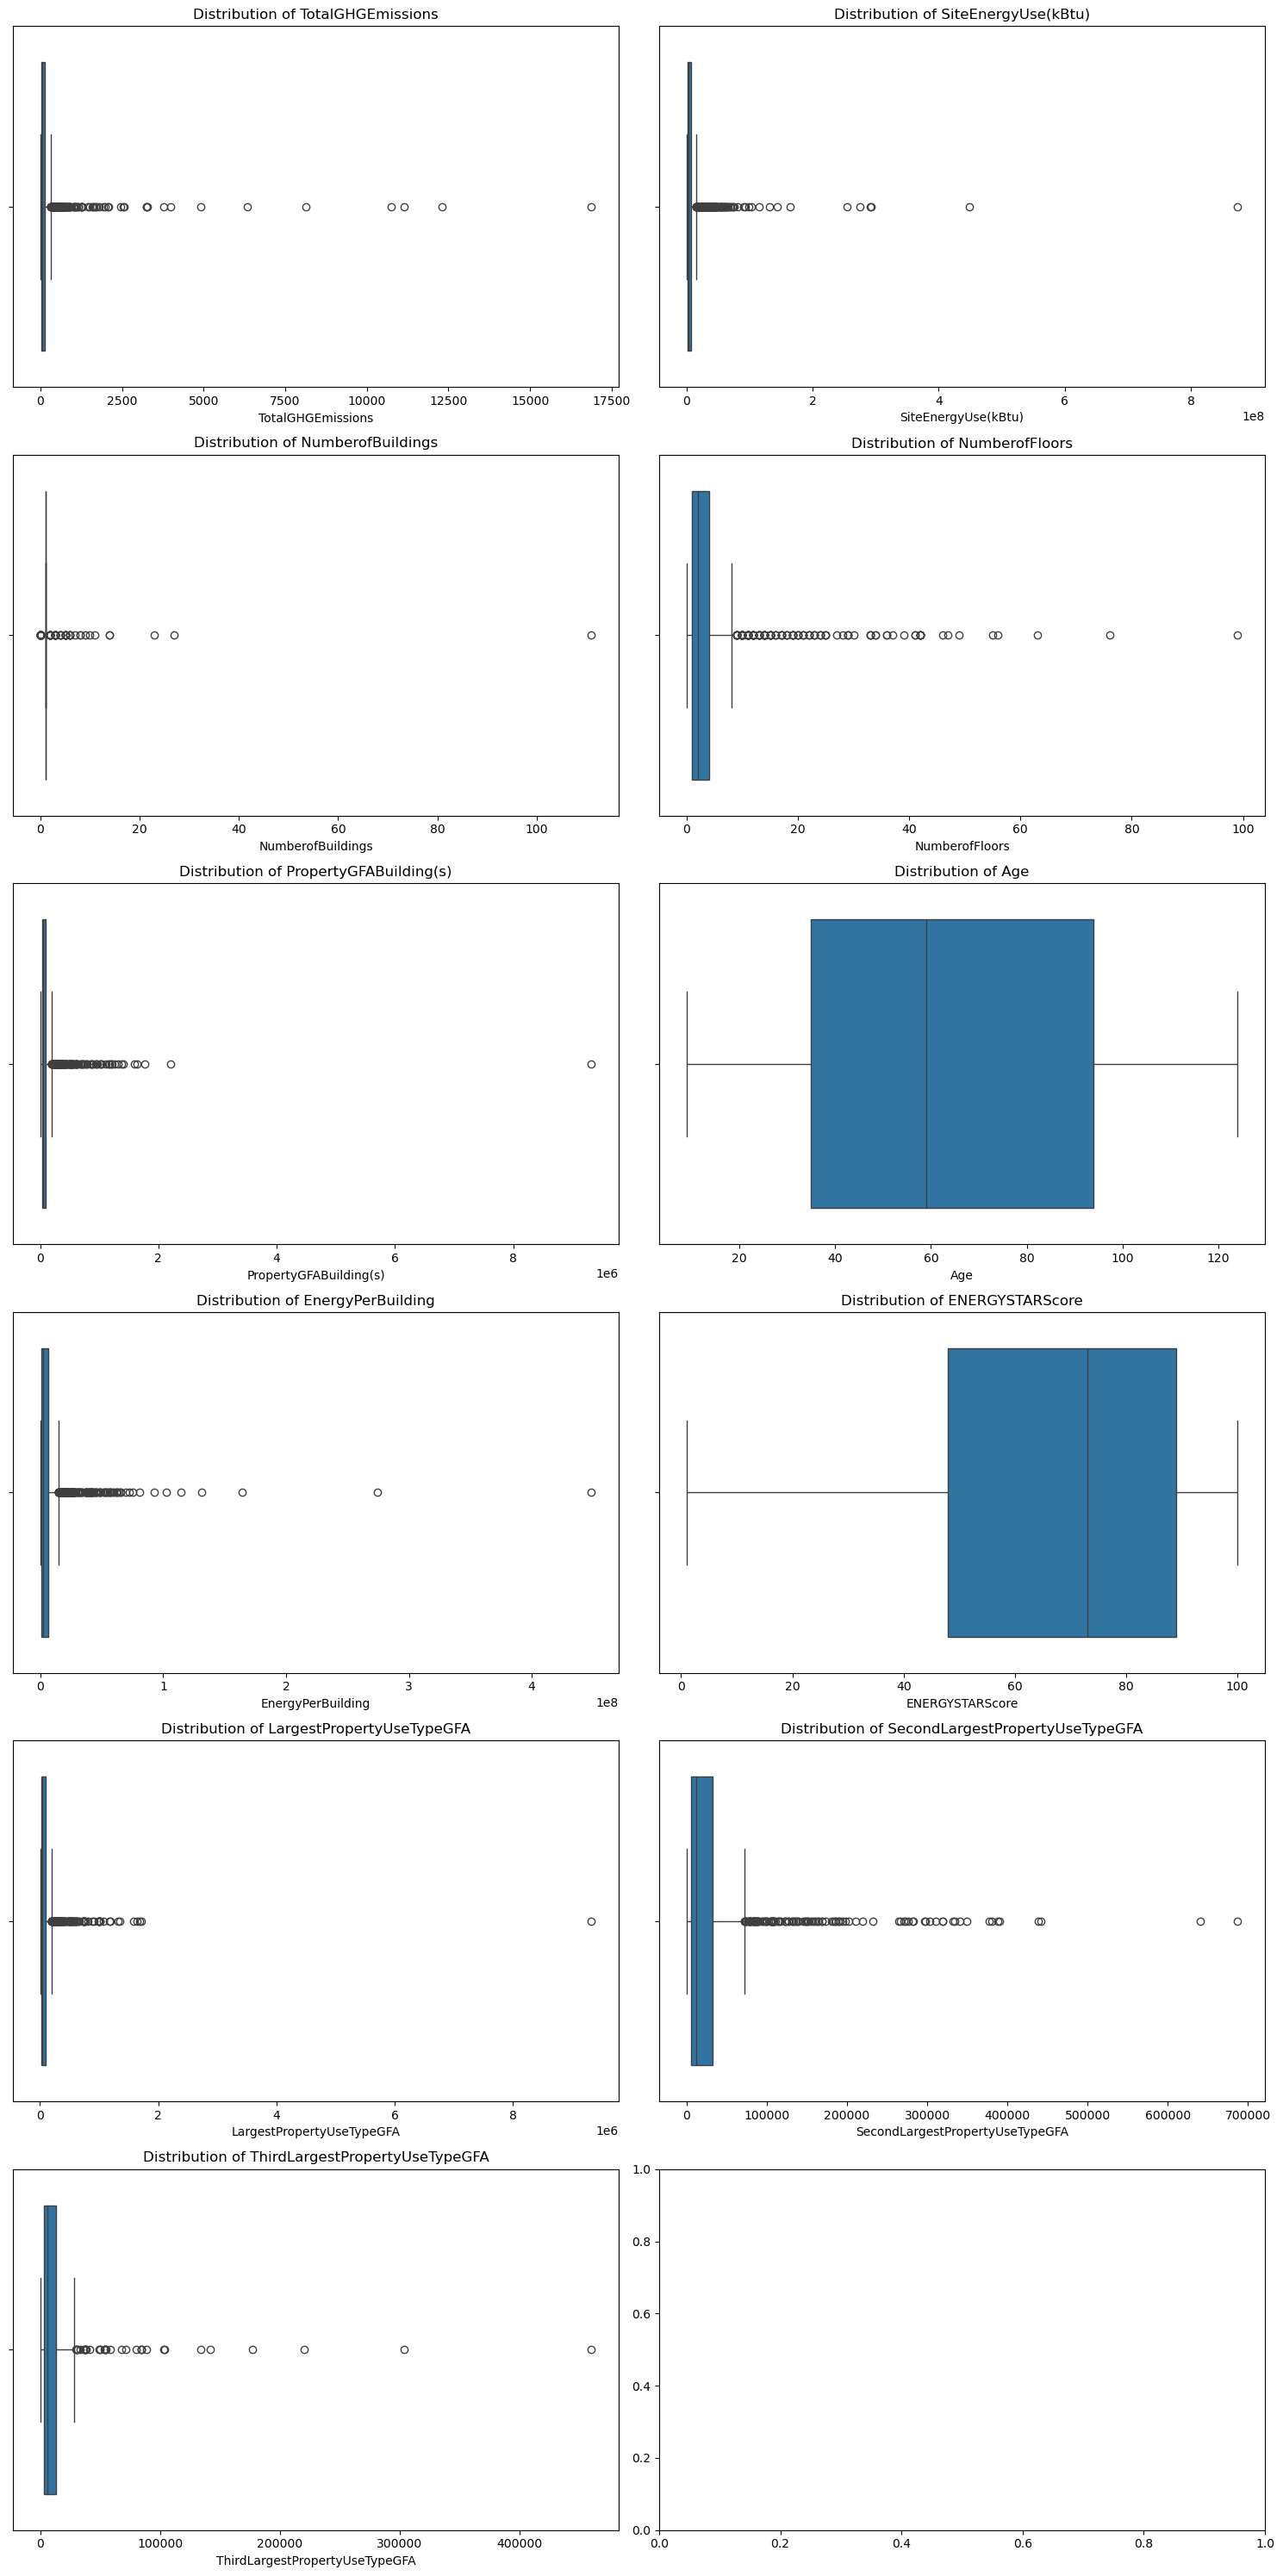

In [24]:
plot_boxplots(X_clean, target + numeric_columns + property_use_GFA)

GHG min -0.80 is not  or so exceptonnal than I can keep it for the model, actually the bigest building in seattle have 76 floor, the 111 buildings is campus so is possible.
I delete some extreme values in the target features because it will create problem in the model training

In [25]:
thresholds = {
	'NumberofBuildings' : (0, 112),
    'NumberofFloors' : (0, 77),
    'PropertyGFABuilding(s)' : (0, 9320157),
    'TotalGHGEmissions' : (0, 5000),
    'SiteEnergyUse(kBtu)' : (0, 150000000)
}

X_imputed = treat_outliers(X_clean, thresholds)
X_imputed[target + numeric_columns + property_use_GFA].describe()

,TotalGHGEmissions,SiteEnergyUse(kBtu),NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),Age,EnergyPerBuilding,ENERGYSTARScore,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
count,1574.00,1574.00,1574.00,1574.00,1574.00,1574.00,1574.00,1051.00,1570.00,812.00,330.00
mean,141.63,6805860.59,1.12,4.10,95146.96,62.38,6369318.19,65.86,88248.24,33300.40,12700.69
std,326.29,12404206.20,1.11,6.20,157989.20,32.77,11217876.06,28.39,145692.50,57621.18,25830.33
min,0.12,16808.90,1.00,1.00,3636.00,9.00,16808.90,1.00,5656.00,0.00,0.00
25%,19.97,1229609.00,1.00,1.00,28182.00,35.00,1208030.78,49.00,25200.00,5068.25,2667.00
50%,49.12,2522355.75,1.00,2.00,46084.00,59.00,2442642.62,74.00,42969.50,11737.00,5884.00
75%,134.61,6785911.25,1.00,4.00,92703.25,94.00,6471110.36,89.00,88415.50,30614.50,12356.50
max,4906.33,143423024.00,27.00,76.00,2200000.00,124.00,131373880.00,100.00,1719643.00,389860.00,303910.00


the last cleaning have naturaly clean the inf because of the division by 0

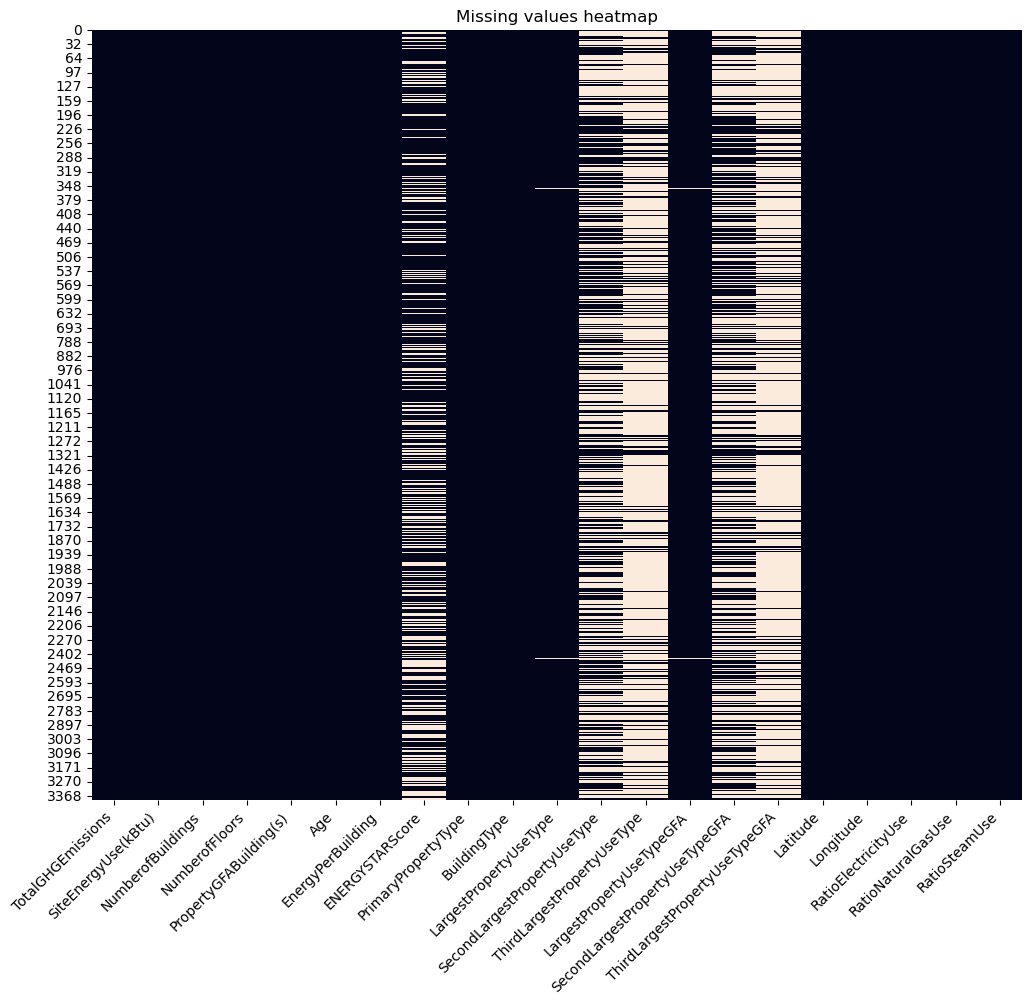

In [26]:
nan_heatmap(X_imputed[feature_keep])

Missing values are in Property Use Type, all data have a primary propertyType so I will put None and 0

In [27]:
X_imputed = fill_property_use_types(X_imputed)

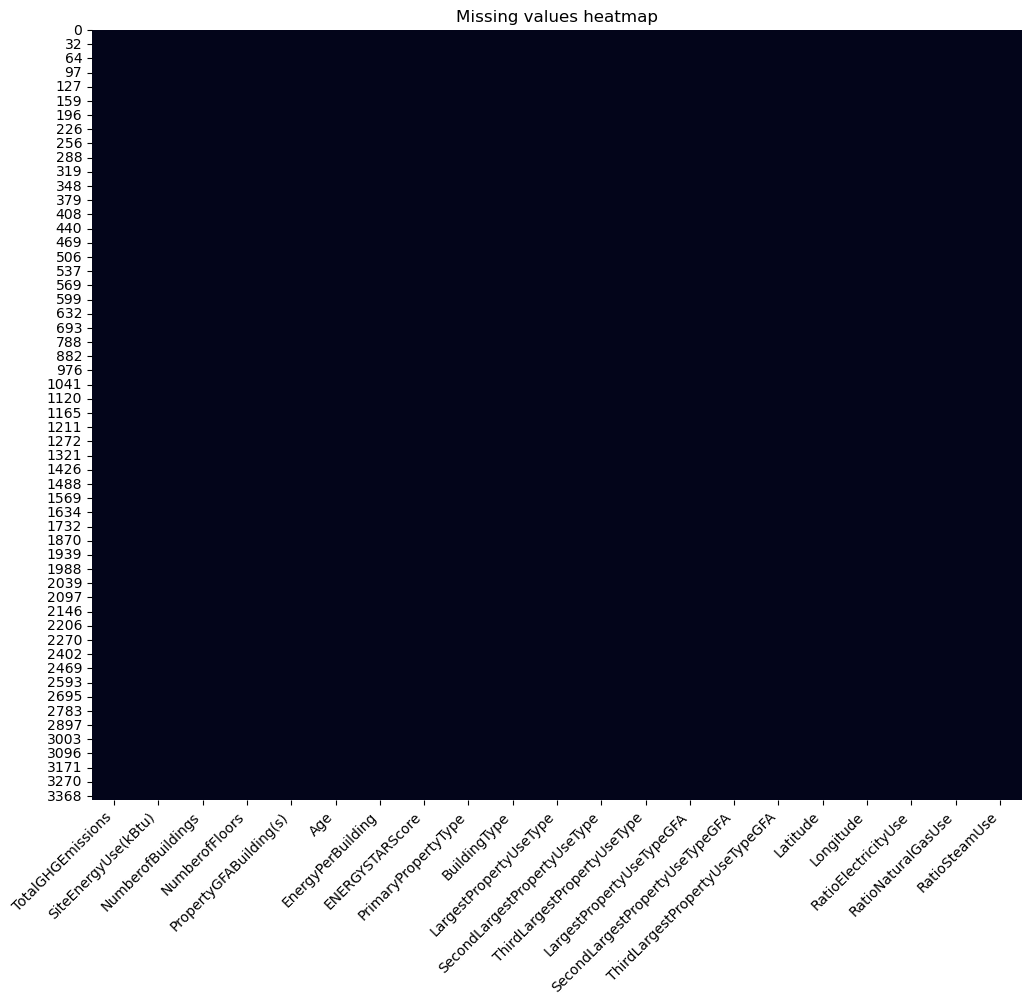

In [28]:
nan_heatmap(X_imputed[feature_keep])

New boxplots to see the repartitions

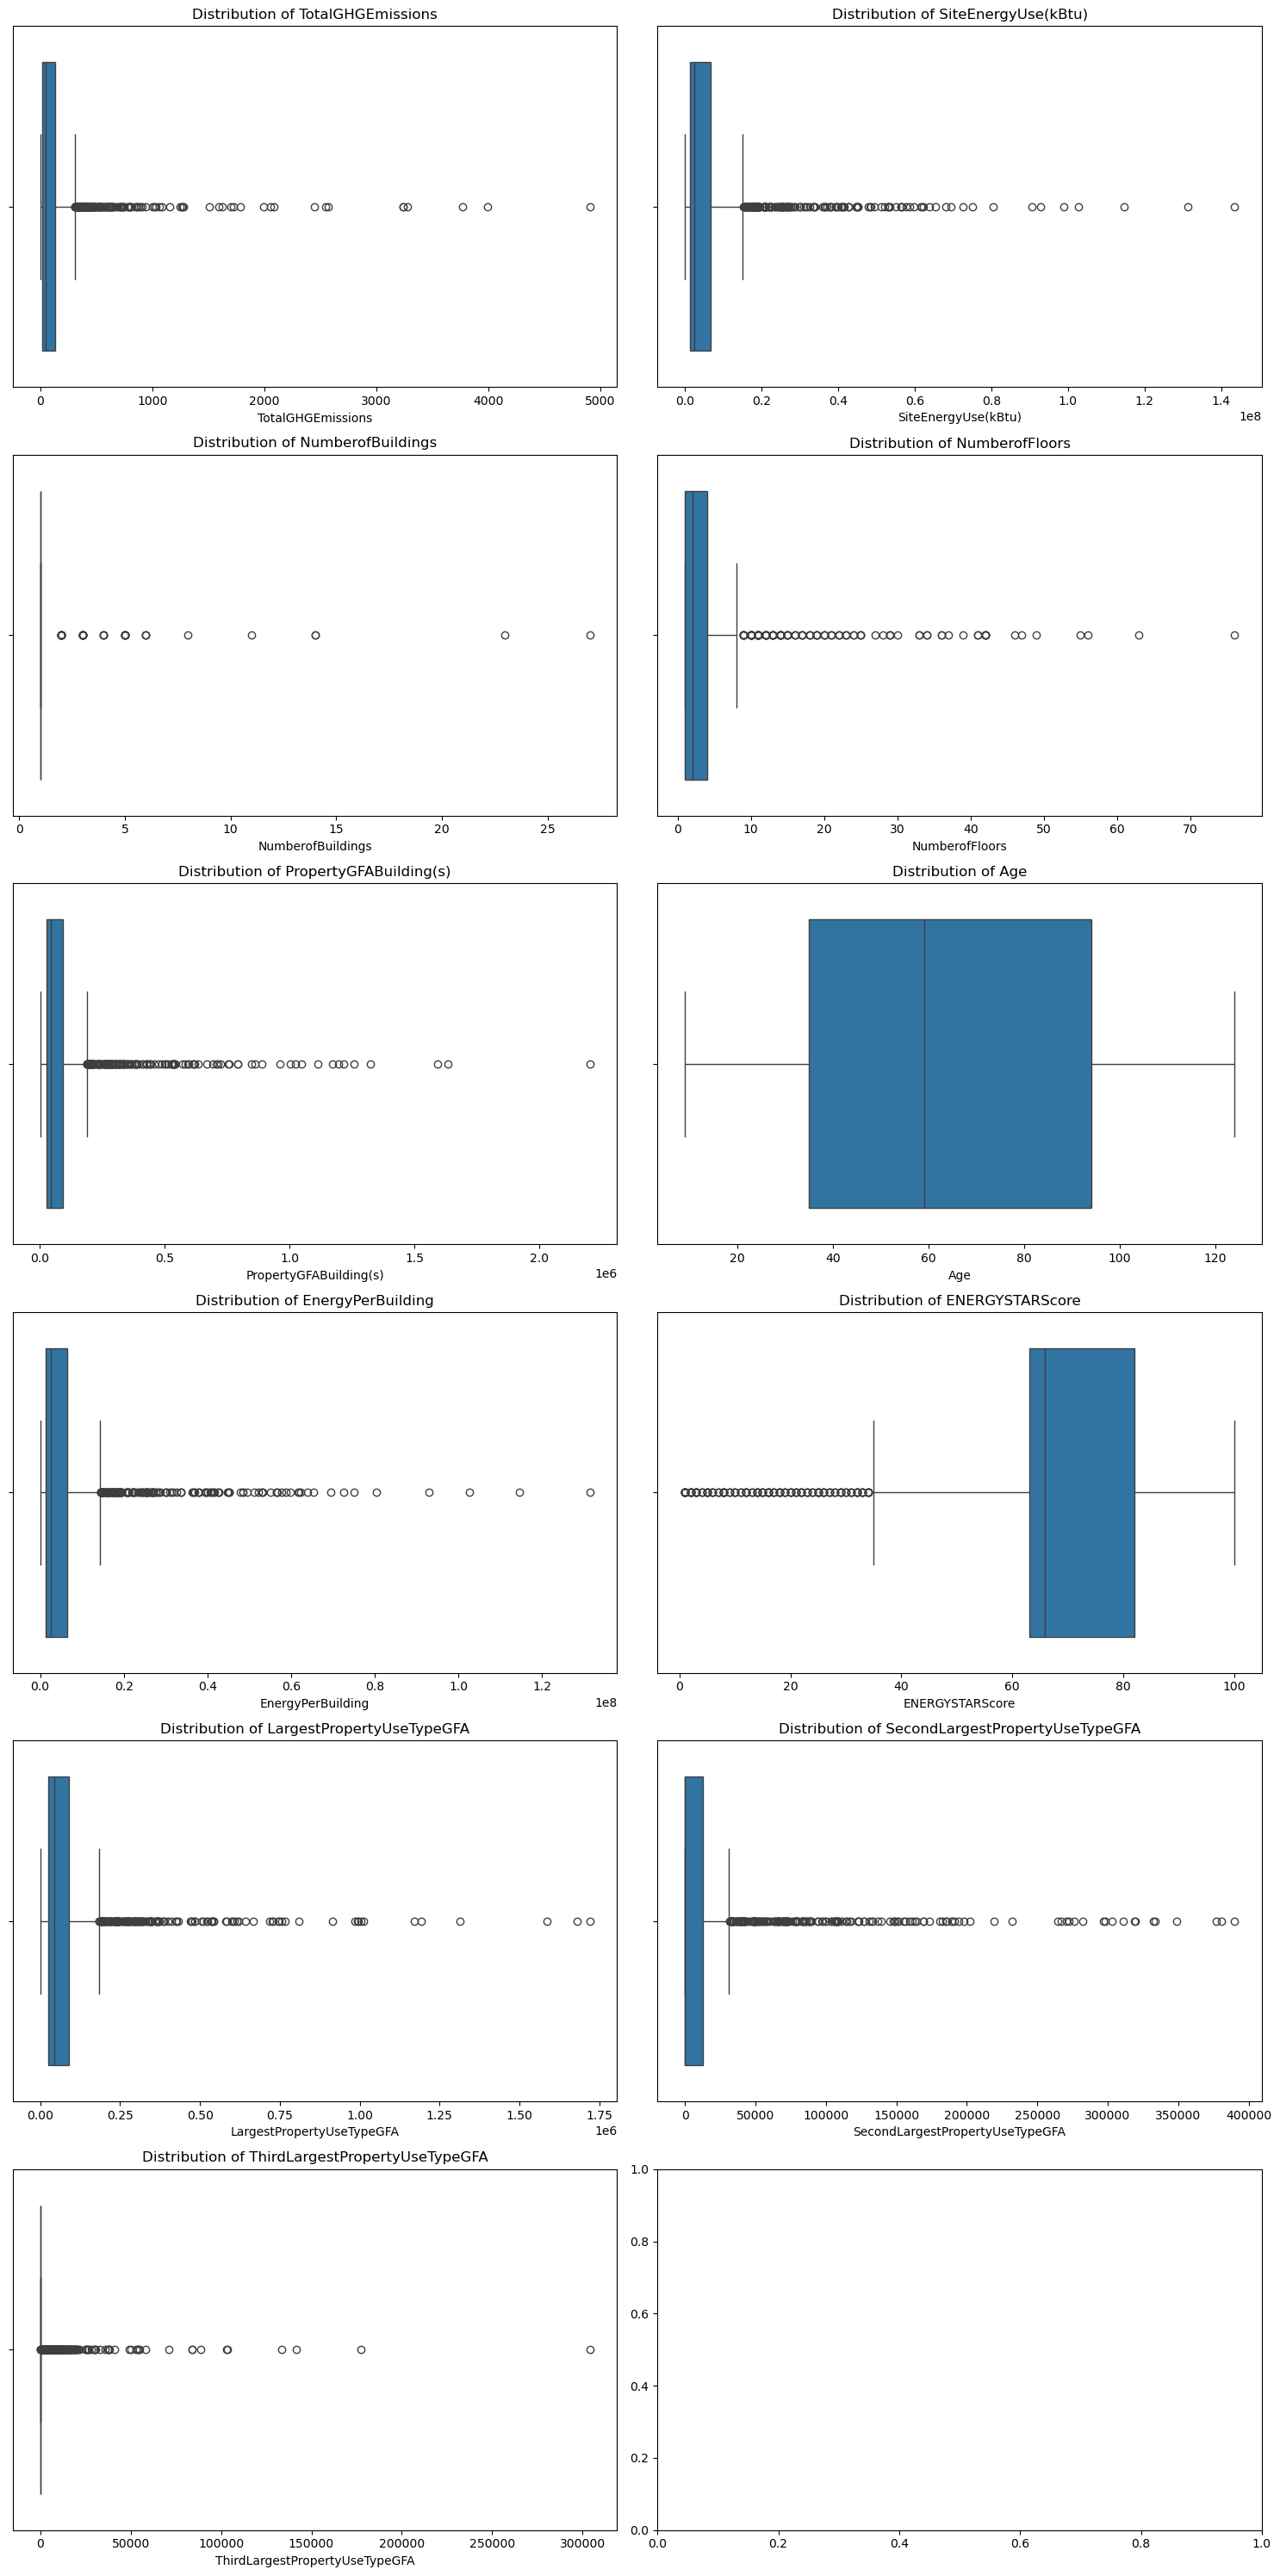

In [29]:
plot_boxplots(X_imputed, target + numeric_columns + property_use_GFA)

we still have some extreme values, but we have a good distribution of age

Let have a look if there is some intresting interactions

(1574,)


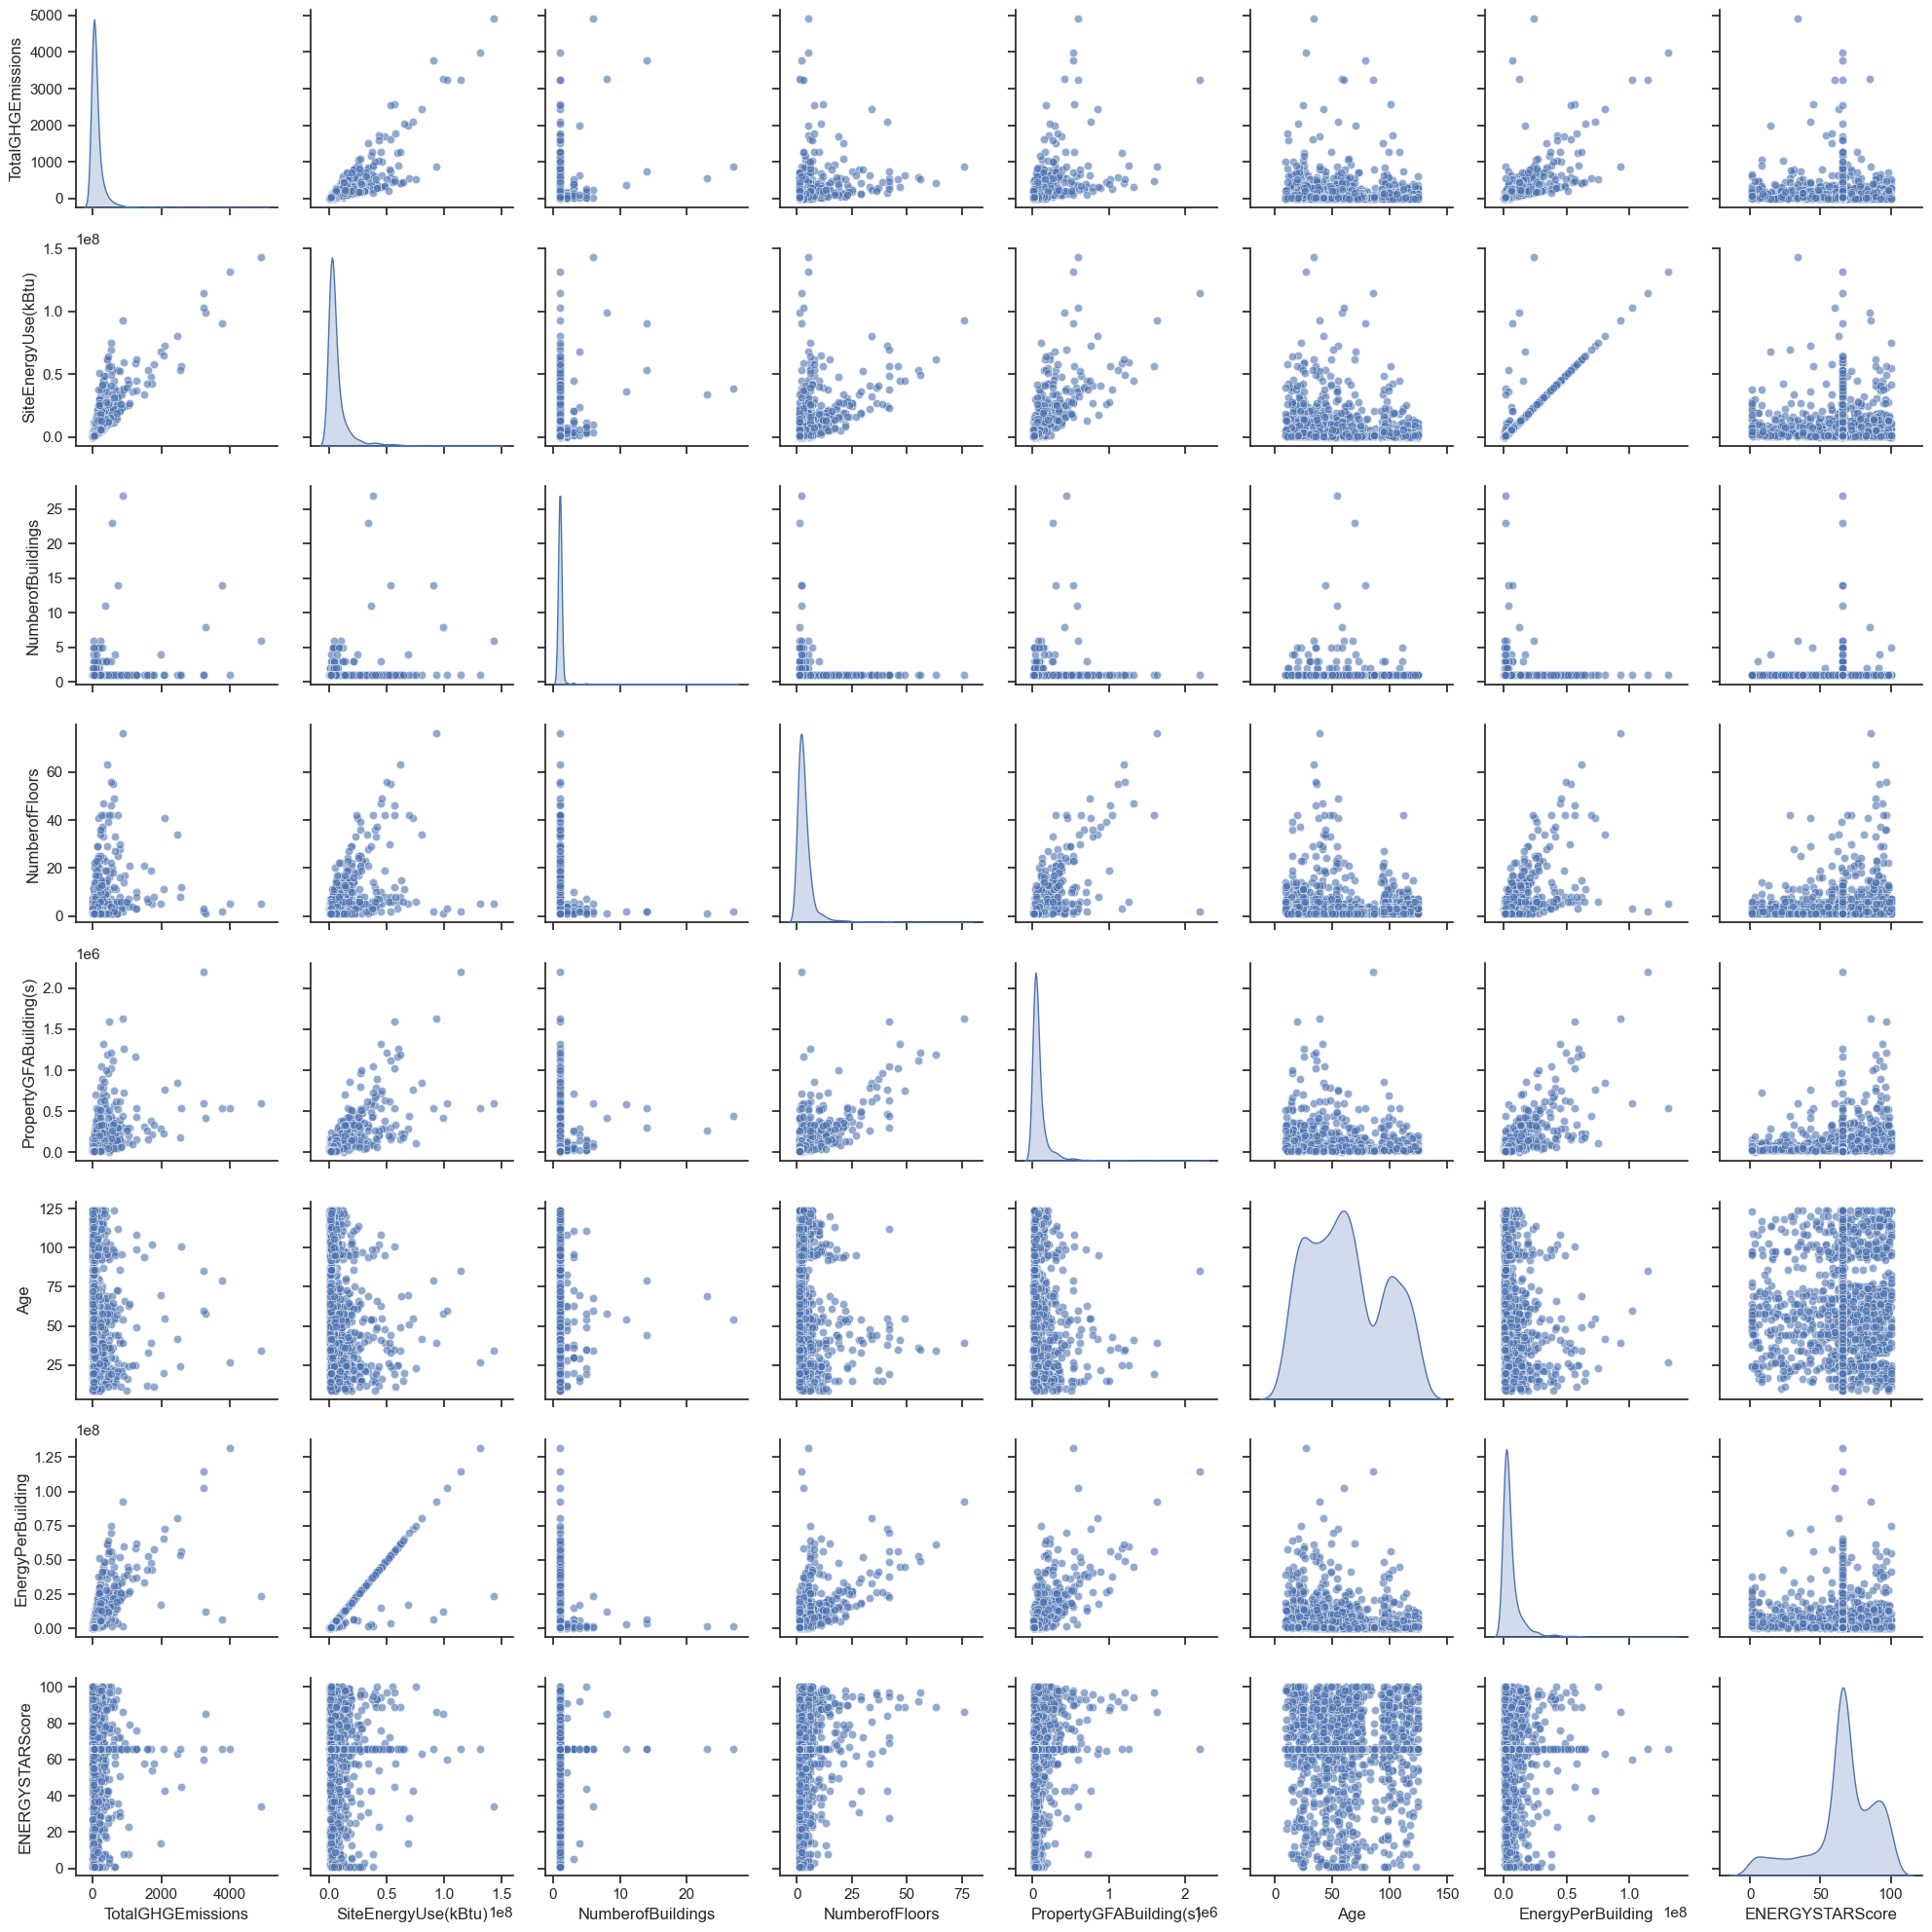

In [30]:
print(X_imputed['RatioNaturalGasUse'].shape)
plot_pairplots(X_imputed, target + numeric_columns)

we can see only a small correlation between ghg and site energy use 

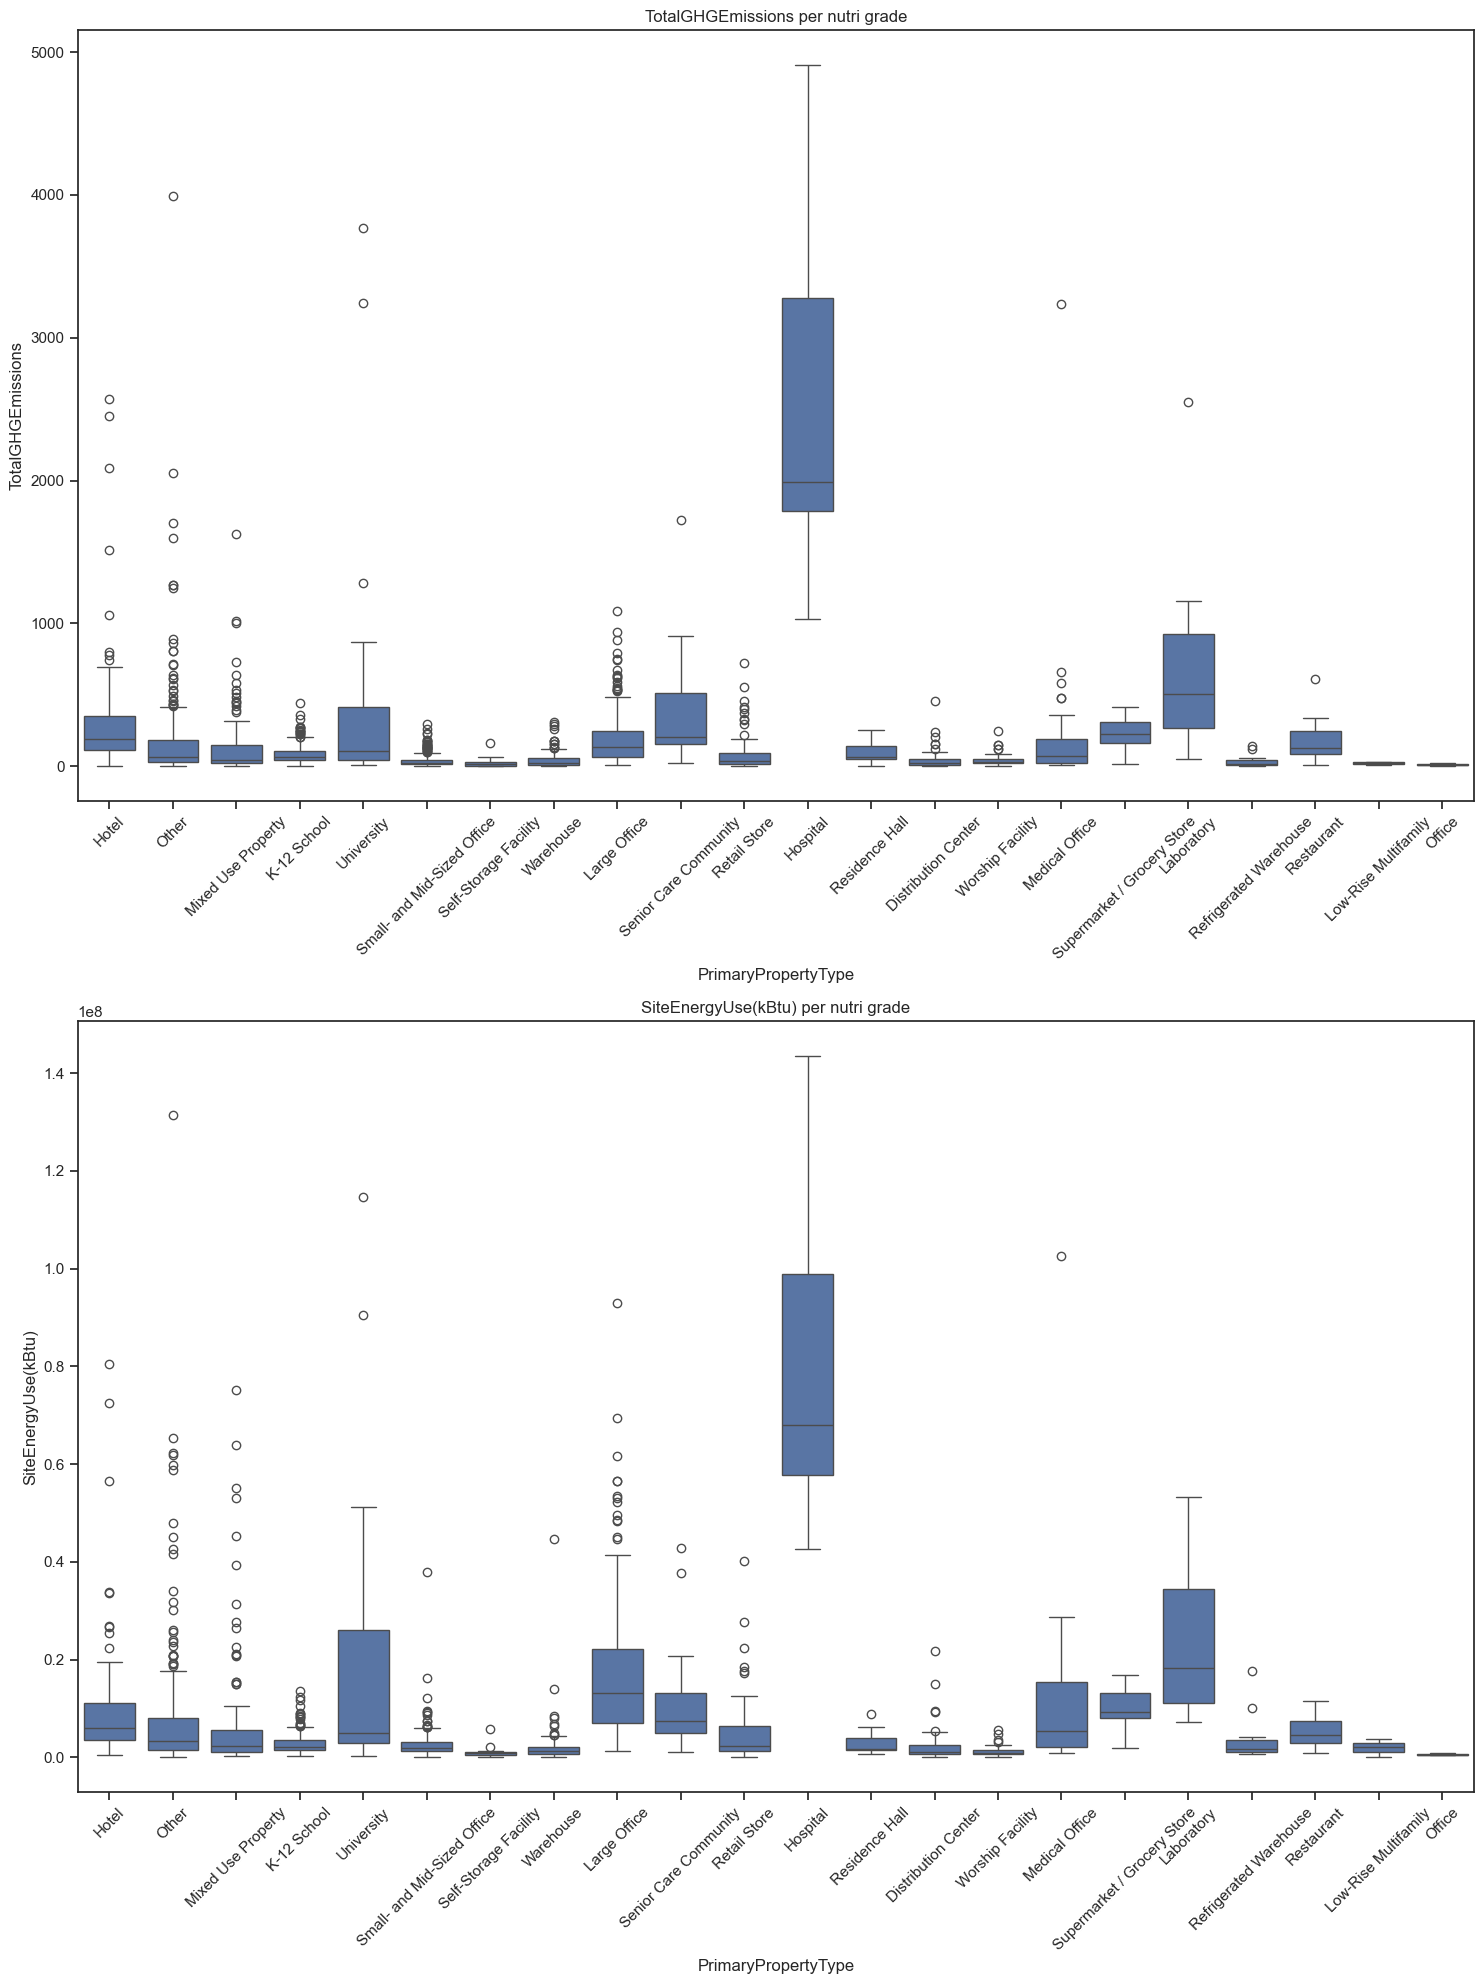

In [31]:
multi_boxplots('PrimaryPropertyType', X_imputed[target], X_imputed['PrimaryPropertyType'], target)

We can see some differences in consuming and the different type of property

Draw a new map, to see if some place in the city have a biger consuming

In [32]:
draw_map_conso(X_imputed)

There is no clear part of the city with big consuming or emisions

PCA, to see the representation of the data

Cumulative variance ratio for 2 components: 57.98%
component 3: 16.94%


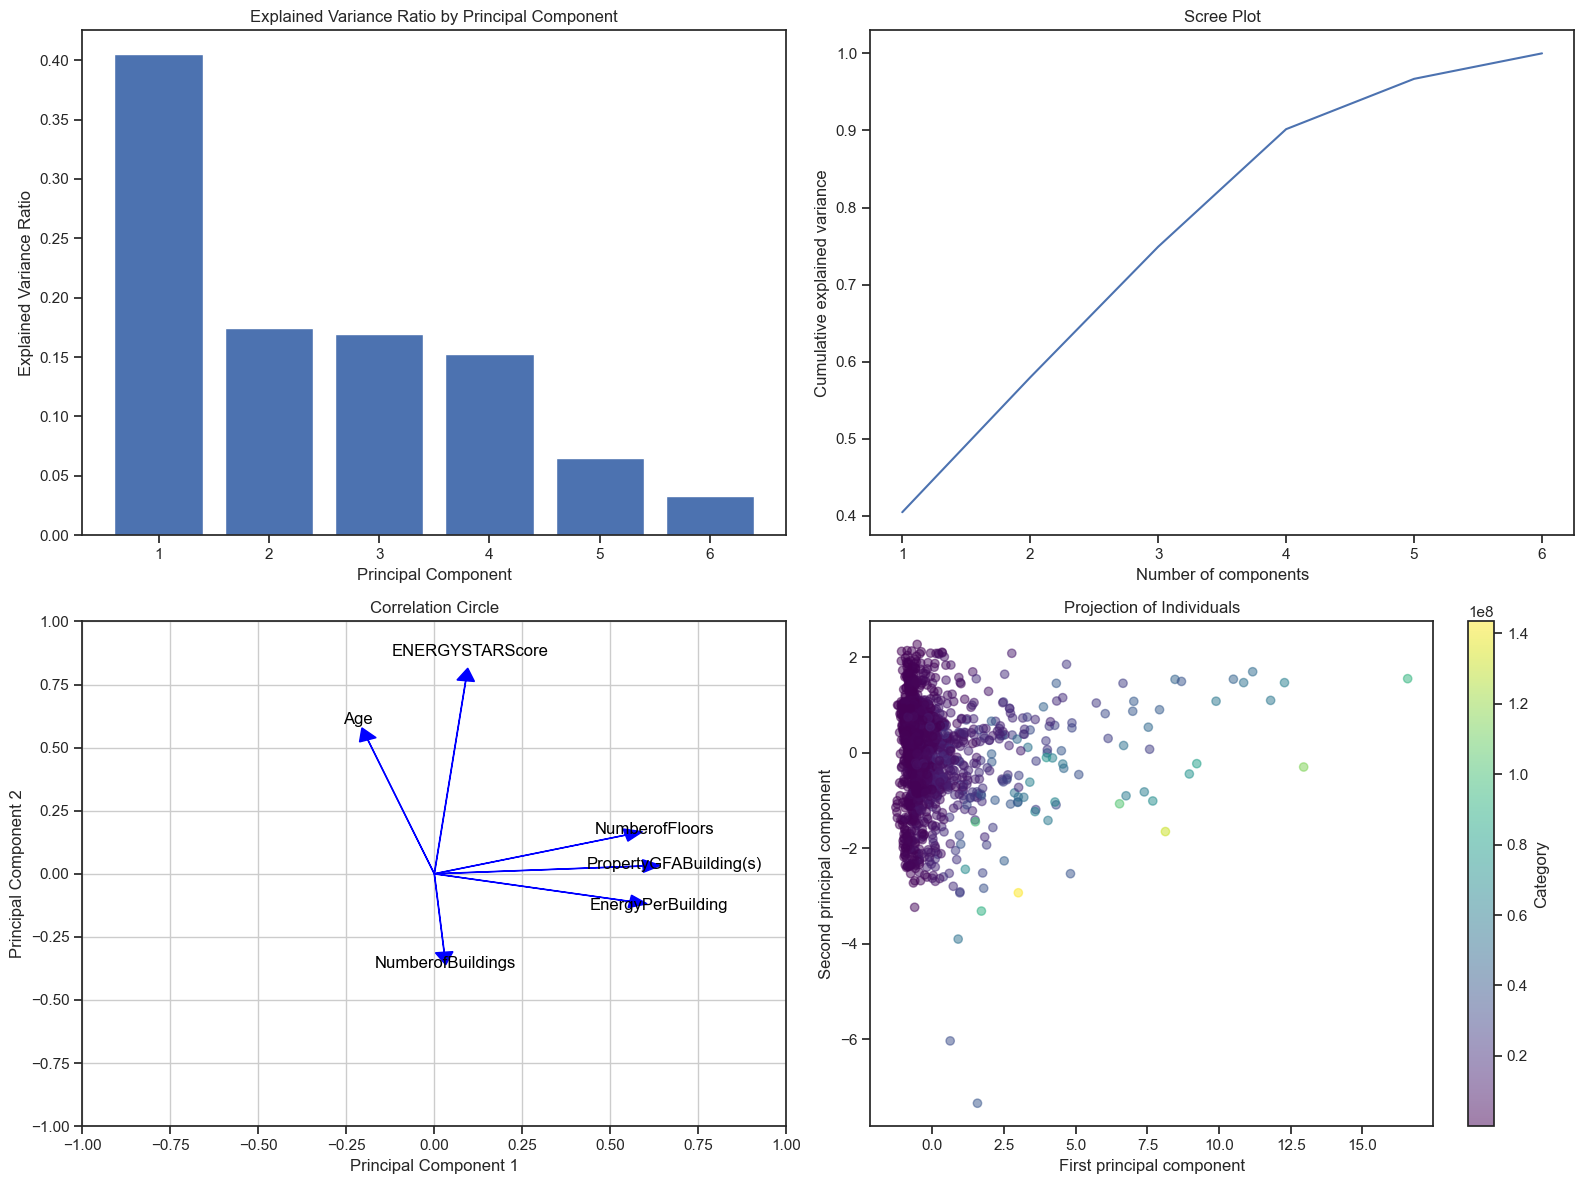

Cumulative variance ratio for 2 components: 57.98%
component 3: 16.94%


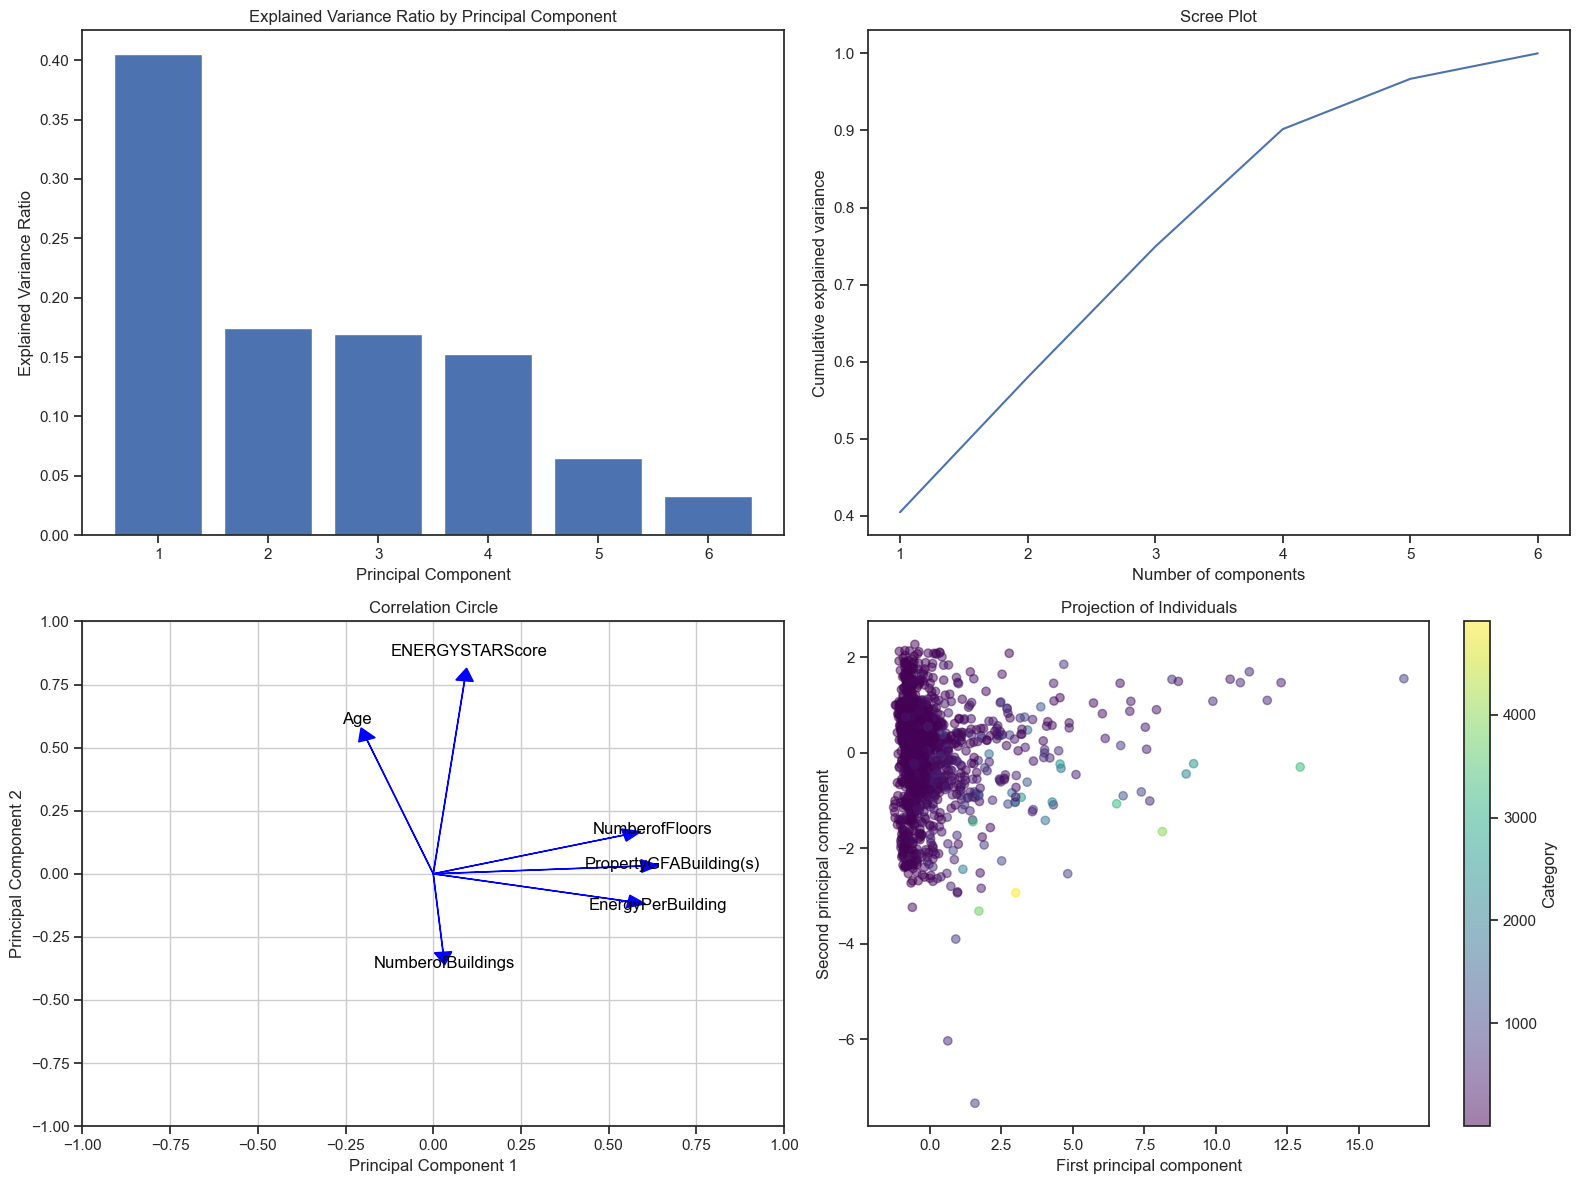

In [33]:
plot_scaler(X_imputed, numeric_columns, X_imputed['SiteEnergyUse(kBtu)'])
plot_scaler(X_imputed, numeric_columns, X_imputed['TotalGHGEmissions'])

Both projection of individual have the same shape, we see a zone with a lot of individuals in a small place and some exeptions with extreme values. 

Transform the qualitative to new columns, for Largest, second, third use the GFA value instead of 0/1

In [34]:
X_transformed, new_columns, to_del = convert_to_quantitative(X_imputed)
feature_keep = [col for col in feature_keep if col not in to_del]
feature_keep.remove('EnergyPerBuilding')
print(feature_keep)
feature_keep += new_columns
print(f'New columns len: {len(new_columns)}')
X_transformed[feature_keep].to_csv('X_clean_with_energystar.csv', index=False)
feature_keep.remove('ENERGYSTARScore')
X_transformed[feature_keep].to_csv('X_clean.csv', index=False)

['TotalGHGEmissions', 'SiteEnergyUse(kBtu)', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)', 'Age', 'ENERGYSTARScore', 'Latitude', 'Longitude', 'RatioElectricityUse', 'RatioNaturalGasUse', 'RatioSteamUse']
New columns len: 54
